<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.05 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 16:56:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 138 kB 45.3 MB/s 
     |████████████████████████████████| 133 kB 42.3 MB/s 
     |████████████████████████████████| 170 kB 54.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 859 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: d3qqrlh8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/d3qqrlh8


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: jikc3zsn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
31/31 [==============================] - 38s 38ms/step - loss: 0.2516 - mean_squared_error: 0.2516 - mean_absolute_error: 0.2590 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0759
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0531 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1152
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0686 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1469
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0699 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0939
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_err

epoch,28
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.03558
val_loss,0.00825
val_mean_squared_error,0.00825
val_mean_absolute_error,0.05827
_runtime,53
_timestamp,1626886677
_step,28
best_val_loss,0.00808


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▃▂▁▂▂▂▂▁▂▁▂▁▁▂▂▁▁▂▁▂▁▁
val_loss,▃▅█▃█▁▂▂▁▁▅▁▁▂▂▂▂▁▁▁▁▁▃▁▂▃▂▃▁
val_mean_squared_error,▃▅█▃█▁▂▂▁▁▅▁▁▂▂▂▂▁▁▁▁▁▃▁▂▃▂▃▁
val_mean_absolute_error,▂▅█▄▇▁▃▃▁▁▆▁▂▂▂▂▂▂▁▁▂▂▃▂▂▄▂▃▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: uvexwkqy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 57ms/step - loss: 0.1731 - mean_squared_error: 0.1731 - mean_absolute_error: 0.3553 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1388
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1430 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1376
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0998 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1474
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0951 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1313
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0119 - mean_squared_erro

epoch,199
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.0457
val_loss,0.01194
val_mean_squared_error,0.01194
val_mean_absolute_error,0.08064
_runtime,35
_timestamp,1626886720
_step,199
best_val_loss,0.01194


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lw2yhb0x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 31ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1060 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0823
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0686 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1018
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0589 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1059
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0505 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0771
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.

epoch,31
loss,0.00213
mean_squared_error,0.00213
mean_absolute_error,0.0358
val_loss,0.00664
val_mean_squared_error,0.00664
val_mean_absolute_error,0.05419
_runtime,13
_timestamp,1626886743
_step,31
best_val_loss,0.00623


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▄▃▃▃▃▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▃▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▄▄▄▃▄▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁
val_loss,▆██▄▃▆▂▃▃▂▂▂▆▁▂▅▂▂▁▁▁▁▄▁▁▁▂▂▂▁▂▁
val_mean_squared_error,▆██▄▃▆▂▃▃▂▂▂▆▁▂▅▂▂▁▁▁▁▄▁▁▁▂▂▂▁▂▁
val_mean_absolute_error,▅▇█▄▂▇▃▄▃▃▂▃▆▂▂▅▃▂▂▁▁▁▅▁▁▁▃▃▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: jwcguc39 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 56ms/step - loss: 0.0991 - mean_squared_error: 0.0991 - mean_absolute_error: 0.2507 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1904
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0982 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0933
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0671 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1033
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0588 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0990
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_erro

epoch,99
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.0379
val_loss,0.00901
val_mean_squared_error,0.00901
val_mean_absolute_error,0.06769
_runtime,21
_timestamp,1626886772
_step,99
best_val_loss,0.00894


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uqr5psxs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 3s 32ms/step - loss: 0.0579 - mean_squared_error: 0.0579 - mean_absolute_error: 0.1717 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0800
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0527 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0852
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0447 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0680
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0781
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,48
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.03012
val_loss,0.00558
val_mean_squared_error,0.00558
val_mean_absolute_error,0.05266
_runtime,19
_timestamp,1626886804
_step,48
best_val_loss,0.0048


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▅▃▄▄▃▄▃▂▂▃▂▂▂▂▂▂▃▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂
val_mean_squared_error,██▅▅▅▃▄▄▃▄▃▂▂▃▂▂▂▂▂▂▃▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂
val_mean_absolute_error,▇█▅▇▆▃▅▅▃▆▃▃▃▃▃▃▃▂▂▃▄▃▂▁▂▁▂▂▂▂▁▁▁▁▁▂▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b4qrxkgf with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 119ms/step - loss: 1.7841 - mean_squared_error: 1.7841 - mean_absolute_error: 0.9582 - val_loss: 0.1148 - val_mean_squared_error: 0.1148 - val_mean_absolute_error: 0.3063
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0847 - mean_squared_error: 0.0847 - mean_absolute_error: 0.2500 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1168
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1596 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1746
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.1015 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1156
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0090

epoch,99
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02657
val_loss,0.00459
val_mean_squared_error,0.00459
val_mean_absolute_error,0.04635
_runtime,18
_timestamp,1626886836
_step,99
best_val_loss,0.00459


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nc5cm1a9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 59ms/step - loss: 0.0926 - mean_squared_error: 0.0926 - mean_absolute_error: 0.2052 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0848
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0812 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0877
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0883 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0719
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0726 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0726
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03625
val_loss,0.00599
val_mean_squared_error,0.00599
val_mean_absolute_error,0.04947
_runtime,14
_timestamp,1626886858
_step,49
best_val_loss,0.00594


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▄▅▃▅▂▂▂▄▂▂█▂▂▁▄▁▂▄▄▁▂▁▁▁▂▂▁▁▁▁▁▁▃▁▃▂▁▁
val_mean_squared_error,▅▇▄▅▃▅▂▂▂▄▂▂█▂▂▁▄▁▂▄▄▁▂▁▁▁▂▂▁▁▁▁▁▁▃▁▃▂▁▁
val_mean_absolute_error,▄▅▃▃▃▆▂▂▂▅▂▂█▂▂▂▅▁▂▄▅▂▃▁▂▁▃▂▂▁▁▁▁▁▃▁▄▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jjldopsx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 121ms/step - loss: 0.0912 - mean_squared_error: 0.0912 - mean_absolute_error: 0.1943 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1547
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1575 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0996
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0652 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1173
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0683 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1601
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0203 - mean_squared_error: 0.0

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,89
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.03079
val_loss,0.00512
val_mean_squared_error,0.00512
val_mean_absolute_error,0.04883
_runtime,18
_timestamp,1626886887
_step,89
best_val_loss,0.00507


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▄▁▄▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
mean_squared_error,█▂▄▁▄▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
mean_absolute_error,█▃▆▂▇▂▂▂▂▄▂▂▃▂▂▃▂▁▂▁▂▂▁▃▁▁▁▁▁▂▁▁▁▂▁▁▃▁▁▁
val_loss,█▄▂▂▃▂▂▂▂▂▁▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▄▂▂▃▂▂▂▂▂▁▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▆▃▃▅▃▂▂▃▃▂▂▂▂▂▂▃▂▃▁▂▃▁▁▁▁▁▂▂▁▁▁▂▂▁▁▃▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gq81mpp2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 33ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1066 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0918
Epoch 2/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0596 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0697
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0557 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0828
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0444 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0661
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_erro

epoch,68
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.03006
val_loss,0.00545
val_mean_squared_error,0.00545
val_mean_absolute_error,0.04892
_runtime,25
_timestamp,1626886928
_step,68
best_val_loss,0.00482


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▂▂▂▃▂▂▂▂▁▁▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▄▄▃▂▂▂▁▁▃▁▂▁▁▂▁▁▁▁▂▁▂▂▁▁▂▂▁▁▃▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▂▄▄▃▂▂▂▁▁▃▁▂▁▁▂▁▁▁▁▂▁▂▂▁▁▂▂▁▁▃▁▁
val_mean_absolute_error,█▅▄▃▃▄▂▂▂▄▅▅▂▃▃▁▁▄▁▂▂▂▃▁▁▁▁▂▁▂▂▁▁▂▂▁▂▄▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wl7by0nf with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 111ms/step - loss: 0.2560 - mean_squared_error: 0.2560 - mean_absolute_error: 0.4431 - val_loss: 0.1311 - val_mean_squared_error: 0.1311 - val_mean_absolute_error: 0.3101
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1529 - mean_squared_error: 0.1529 - mean_absolute_error: 0.3267 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1738
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - mean_absolute_error: 0.2052 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1180
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1372 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1352
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - mean_squared_error: 0.0198

epoch,99
loss,0.00456
mean_squared_error,0.00456
mean_absolute_error,0.05489
val_loss,0.01657
val_mean_squared_error,0.01657
val_mean_absolute_error,0.09655
_runtime,17
_timestamp,1626886977
_step,99
best_val_loss,0.01657


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gimzimej with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 4s 30ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1619 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0789
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0555 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0828
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0467 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0727
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0404 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0662
Epoch 5/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_err

epoch,73
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.03152
val_loss,0.00473
val_mean_squared_error,0.00473
val_mean_absolute_error,0.04741
_runtime,26
_timestamp,1626887021
_step,73
best_val_loss,0.0046


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▄▃▂▂▂▂▂▂▂▃▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▄▃▂▂▂▂▂▂▂▃▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▆▃▃▃▂▂▂▂▂▃▂▁▃▁▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dyrqvwj5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 59ms/step - loss: 0.1070 - mean_squared_error: 0.1070 - mean_absolute_error: 0.2539 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1147
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0741 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1190
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0618 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0986
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0574 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0972
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_erro

epoch,146
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.03176
val_loss,0.00804
val_mean_squared_error,0.00804
val_mean_absolute_error,0.06161
_runtime,31
_timestamp,1626887081
_step,146
best_val_loss,0.00801


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1u873kyn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 58ms/step - loss: 2.1656 - mean_squared_error: 2.1656 - mean_absolute_error: 0.8202 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1152
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0844 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1148
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0772 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0654
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0652 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0616
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_err

epoch,23
loss,0.00384
mean_squared_error,0.00384
mean_absolute_error,0.04791
val_loss,0.02039
val_mean_squared_error,0.02039
val_mean_absolute_error,0.126
_runtime,13
_timestamp,1626887120
_step,23
best_val_loss,0.00596


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▂▁▁▁▁▅▂▁▁▁▁▁▁▁▁
val_loss,▅▆▂▂▂▁▂▁▂▃▁▁▁▁█▃▃▄▄▆▂▂▂▅
val_mean_squared_error,▅▆▂▂▂▁▂▁▂▃▁▁▁▁█▃▃▄▄▆▂▂▂▅
val_mean_absolute_error,▆▆▂▂▃▁▃▂▃▄▁▁▂▂█▃▃▅▅█▂▂▂▇
_runtime,▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆███
_timestamp,▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: hxazj1kt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 33ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - mean_absolute_error: 0.1918 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1114
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0575 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0863
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0490 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0879
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0451 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0765
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,46
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.02838
val_loss,0.00595
val_mean_squared_error,0.00595
val_mean_absolute_error,0.05714
_runtime,20
_timestamp,1626887149
_step,46
best_val_loss,0.00512


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▄▄▃▂▂▃▃▂▃▂▂▂▂▂▂▁▂▂▃▁▁▂▁▁▂▃▁▃▁▂▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jwz12814 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 65ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - mean_absolute_error: 0.2236 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0770
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0818 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0722
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0618 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0710
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0493 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0806
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_err

epoch,99
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02918
val_loss,0.00496
val_mean_squared_error,0.00496
val_mean_absolute_error,0.04909
_runtime,24
_timestamp,1626887183
_step,99
best_val_loss,0.00471


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▆▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇█▆▄▅▄▂▂▃▂▂▃▃▂▁▁▁▂▃▃▁▁▄▁▂▁▂▂▂▁▁▂▁▁▁▄▂▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fukztfqm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 53ms/step - loss: 2.3533 - mean_squared_error: 2.3533 - mean_absolute_error: 0.7262 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1109
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0543 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0767
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1128 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0763
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0828 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1367
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0139 - mean_squared_erro

epoch,45
loss,0.00316
mean_squared_error,0.00316
mean_absolute_error,0.04435
val_loss,0.01026
val_mean_squared_error,0.01026
val_mean_absolute_error,0.0781
_runtime,14
_timestamp,1626887212
_step,45
best_val_loss,0.00878


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂▆▃▂▅█▃▃▅▂▂▂▂▂▂▃▂▂▄▁▁▁▁▄▁▂▂▂▁▁▁▅▂▁▁▂▁▂
val_mean_squared_error,▄▂▂▆▃▂▅█▃▃▅▂▂▂▂▂▂▃▂▂▄▁▁▁▁▄▁▂▂▂▁▁▁▅▂▁▁▂▁▂
val_mean_absolute_error,▅▂▂▇▃▂▄█▄▄▆▂▂▂▃▃▁▄▃▂▃▁▁▁▂▄▂▃▃▁▁▁▂▅▃▂▁▂▂▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: dqya2rsy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 61ms/step - loss: 0.0830 - mean_squared_error: 0.0830 - mean_absolute_error: 0.2099 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0834
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0702 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0821
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0589 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0994
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0548 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0964
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0

epoch,49
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.02906
val_loss,0.00623
val_mean_squared_error,0.00623
val_mean_absolute_error,0.05427
_runtime,16
_timestamp,1626887239
_step,49
best_val_loss,0.00605


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▇▅▄▄▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▃▁▁▂▂▂▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,█▇█▇▅▄▄▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▃▁▁▂▂▂▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,▆▅██▆▅▄▃▃▄▂▄▄▃▂▃▃▂▂▂▂▂▂▄▂▁▂▂▂▁▁▁▂▂▃▁▂▂▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gs57nucy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 31ms/step - loss: 0.0710 - mean_squared_error: 0.0710 - mean_absolute_error: 0.1946 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1360
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0637 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0895
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0898
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0492 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0788
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,49
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02752
val_loss,0.00505
val_mean_squared_error,0.00505
val_mean_absolute_error,0.04692
_runtime,19
_timestamp,1626887270
_step,49
best_val_loss,0.00494


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▂▃▂▂▂▂▂▂▁▁▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xlnu7pmh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 4s 32ms/step - loss: 1.6530 - mean_squared_error: 1.6530 - mean_absolute_error: 0.5116 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1755
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1755 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1503
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1153 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1516
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.1051 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0848
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0107 - mean_squared_error: 0.

epoch,49
loss,0.00252
mean_squared_error,0.00252
mean_absolute_error,0.03896
val_loss,0.01
val_mean_squared_error,0.01
val_mean_absolute_error,0.06751
_runtime,20
_timestamp,1626887301
_step,49
best_val_loss,0.00748


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▃▃▂▂▄▂▂▂▁▁▁▁▁▂▁▂▁▁▂▁▂▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▇▆▃▃▂▂▄▂▂▂▁▁▁▁▁▂▁▂▁▁▂▁▂▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▇▃▄▁▃▄▂▂▂▁▁▂▁▂▂▁▃▁▂▂▁▃▁▂▁▄▁▂▁▁▂▁▁▁▁▂▁▂
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cusnd1jj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 116ms/step - loss: 3.7999 - mean_squared_error: 3.7999 - mean_absolute_error: 1.0520 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1056
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0561 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1078
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0880
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0564 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1605
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0772 - mean_squared_error: 0.077

epoch,57
loss,0.00418
mean_squared_error,0.00418
mean_absolute_error,0.05141
val_loss,0.00938
val_mean_squared_error,0.00938
val_mean_absolute_error,0.06358
_runtime,14
_timestamp,1626887334
_step,57
best_val_loss,0.00924


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▃▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▂▄▂▂▄▄█▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▃▄▂▄▂▂▄▄█▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▅▅▃▆▂▂▄▄█▄▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8b3iwwye with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 33ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - mean_absolute_error: 0.1613 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0856
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0654 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.0981
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0869 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0643
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0724 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0845
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,48
loss,0.00162
mean_squared_error,0.00162
mean_absolute_error,0.03112
val_loss,0.00654
val_mean_squared_error,0.00654
val_mean_absolute_error,0.05233
_runtime,20
_timestamp,1626887365
_step,48
best_val_loss,0.0057


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▃▄█▂▂▂▂▂▃▂▂▁▂▄▁▁▁▁▁▂▁▁▁▄▁▂▁▁▁▁▁▂▂▃▂▁▂▁
val_mean_squared_error,▅▇▃▄█▂▂▂▂▂▃▂▂▁▂▄▁▁▁▁▁▂▁▁▁▄▁▂▁▁▁▁▁▂▂▃▂▁▂▁
val_mean_absolute_error,▄▅▂▄█▂▂▂▃▂▄▂▃▁▃▅▁▁▂▁▂▃▂▂▁▅▁▂▁▁▂▁▁▃▂▄▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vhggihpa with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 4s 114ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - mean_absolute_error: 0.3484 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1568
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1542 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1174
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0864 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1672
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.1073 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1411
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - me

epoch,49
loss,0.00404
mean_squared_error,0.00404
mean_absolute_error,0.05122
val_loss,0.01416
val_mean_squared_error,0.01416
val_mean_absolute_error,0.08574
_runtime,14
_timestamp,1626887396
_step,49
best_val_loss,0.01416


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▆▄▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▆▄▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▄█▆▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████████
_timestamp,▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: aza3fyiv with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 32ms/step - loss: 0.1104 - mean_squared_error: 0.1104 - mean_absolute_error: 0.1910 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0889
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0756 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1294
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0916 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1718
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0922 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0667
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0082 - mean_squared_error: 0.

epoch,49
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.03231
val_loss,0.00492
val_mean_squared_error,0.00492
val_mean_absolute_error,0.04784
_runtime,21
_timestamp,1626887429
_step,49
best_val_loss,0.00452


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅█▃▃▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▃▅█▃▃▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▃▆█▂▄▂▂▂▂▂▂▁▁▂▁▂▃▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f669ryr9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 96ms/step - loss: 1.3461 - mean_squared_error: 1.3461 - mean_absolute_error: 0.6364 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1746
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0941 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0745
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0709 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0678
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0565 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0629
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_squared_err

epoch,17
loss,0.00552
mean_squared_error,0.00552
mean_absolute_error,0.05636
val_loss,0.00922
val_mean_squared_error,0.00922
val_mean_absolute_error,0.0733
_runtime,13
_timestamp,1626887454
_step,17
best_val_loss,0.00677


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▂▇▂▂▁▂▁▁▁▁
val_loss,▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▁▁▁▁▂▁▁█▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆█
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: pd855qbr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 4s 34ms/step - loss: 0.1525 - mean_squared_error: 0.1525 - mean_absolute_error: 0.3028 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1648
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0849 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1120
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0693 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1096
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0649 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1100
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_squared_error: 0.

epoch,49
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04557
val_loss,0.01189
val_mean_squared_error,0.01189
val_mean_absolute_error,0.077
_runtime,21
_timestamp,1626887487
_step,49
best_val_loss,0.01189


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dj5h5is5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 34ms/step - loss: 0.0795 - mean_squared_error: 0.0795 - mean_absolute_error: 0.1958 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0838
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0930 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1157
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0627 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1064
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0704 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0740
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0

epoch,46
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.03016
val_loss,0.00519
val_mean_squared_error,0.00519
val_mean_absolute_error,0.05312
_runtime,23
_timestamp,1626887522
_step,46
best_val_loss,0.00447


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▅▂▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▆▃▃█▂▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▇▇▆▃▃█▂▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▄▇▆▄▃█▃▂▁▁▁▁▁▂▁▁▂▃▃▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▃▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0mvcxd63 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 123ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - mean_absolute_error: 0.2495 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1024
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0996 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1344
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0838 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1514
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0854 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1222
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0070 - mean_squared_error: 0.007

epoch,99
loss,0.00371
mean_squared_error,0.00371
mean_absolute_error,0.0481
val_loss,0.01307
val_mean_squared_error,0.01307
val_mean_absolute_error,0.08129
_runtime,20
_timestamp,1626887558
_step,99
best_val_loss,0.01307


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fn2bu2k7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 59ms/step - loss: 0.2277 - mean_squared_error: 0.2277 - mean_absolute_error: 0.3679 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1977
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0899 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1385
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0672 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0925
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0554 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0934
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_erro

epoch,91
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02901
val_loss,0.00726
val_mean_squared_error,0.00726
val_mean_absolute_error,0.05737
_runtime,24
_timestamp,1626887603
_step,91
best_val_loss,0.00581


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6yf739gz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 31ms/step - loss: 0.0591 - mean_squared_error: 0.0591 - mean_absolute_error: 0.1668 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0948
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0826
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0470 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0748
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0395 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0664
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,69
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02754
val_loss,0.00465
val_mean_squared_error,0.00465
val_mean_absolute_error,0.04501
_runtime,26
_timestamp,1626887642
_step,69
best_val_loss,0.0045


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▂▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▃▃▄▂▂▄▃▂▂▃▄▂▃▃▂▁▂▂▁▂▂▂▁▂▂▂▂▁▁▃▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mxr1gwlr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 33ms/step - loss: 1.6137 - mean_squared_error: 1.6137 - mean_absolute_error: 0.4879 - val_loss: 0.1454 - val_mean_squared_error: 0.1454 - val_mean_absolute_error: 0.3569
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - mean_absolute_error: 0.1823 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0833
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0833 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0864
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0773 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1693
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0095 - mean_squared_erro

epoch,35
loss,0.00288
mean_squared_error,0.00288
mean_absolute_error,0.04152
val_loss,0.00917
val_mean_squared_error,0.00917
val_mean_absolute_error,0.07348
_runtime,20
_timestamp,1626887695
_step,35
best_val_loss,0.00773


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▄▃▁▃▂▁▁▂▁▁▂▁▁▁▂▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mc2jykxj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 62ms/step - loss: 1.9944 - mean_squared_error: 1.9944 - mean_absolute_error: 0.7797 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1004
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0773 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0737
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1033 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0873
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0606
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 

epoch,18
loss,0.00461
mean_squared_error,0.00461
mean_absolute_error,0.05257
val_loss,0.00955
val_mean_squared_error,0.00955
val_mean_absolute_error,0.06
_runtime,13
_timestamp,1626887723
_step,18
best_val_loss,0.00787


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▂▁▁▁▁▁▂▅▂▂▂▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁█▁▂▁▁▁▁
_runtime,▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆████
_timestamp,▁▁▁▁▃▃▃▃▃▆▆▆▆▆▆████
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: sj8fguk7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 126ms/step - loss: 2.7123 - mean_squared_error: 2.7123 - mean_absolute_error: 1.0172 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1909
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1550 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1339
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0883 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1191
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0746 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1062
Epoch 5/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0105 - mean_squared_error: 0.0

epoch,46
loss,0.02118
mean_squared_error,0.02118
mean_absolute_error,0.10526
val_loss,0.1622
val_mean_squared_error,0.1622
val_mean_absolute_error,0.38495
_runtime,16
_timestamp,1626887753
_step,46
best_val_loss,0.00554


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
val_mean_squared_error,▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
val_mean_absolute_error,▄▃▂▂▃▁▁▁▃▂▁▁▁▂▂▂▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uribx643 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 132ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - mean_absolute_error: 0.2048 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1220
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0591 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1082
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0561 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0945
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0547 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0999
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0046 - mean_squared_error: 0.

epoch,76
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02963
val_loss,0.00821
val_mean_squared_error,0.00821
val_mean_absolute_error,0.07136
_runtime,22
_timestamp,1626887789
_step,76
best_val_loss,0.00565


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▃▂▂▂▁▂▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▇▆▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▂▂▁▂▁▁▁▁▁▂▂
val_mean_squared_error,█▇▆▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▂▂▁▂▁▁▁▁▁▂▂
val_mean_absolute_error,█▇▆▅▃▃▃▂▃▃▂▂▃▃▃▂▂▂▂▁▂▂▂▂▁▂▃▃▁▃▂▁▂▂▁▂▂▂▃▃
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qhd2a8qx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 3s 123ms/step - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.2488 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0837
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1186 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1320
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0814 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0862
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0625 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0947
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0

epoch,56
loss,0.00141
mean_squared_error,0.00141
mean_absolute_error,0.02902
val_loss,0.00572
val_mean_squared_error,0.00572
val_mean_absolute_error,0.05101
_runtime,17
_timestamp,1626887819
_step,56
best_val_loss,0.00572


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▄▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▄▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kvlwc20s with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 35ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1603 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0776
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0561 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0893
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0473 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0771
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0446 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0624
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_erro

epoch,56
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02695
val_loss,0.00465
val_mean_squared_error,0.00465
val_mean_absolute_error,0.04751
_runtime,25
_timestamp,1626887861
_step,56
best_val_loss,0.00463


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▄▃▄▂▂▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,██▆▄▄▃▄▂▂▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▄▄▄▅▃▂▃▃▃▂▃▁▁▂▂▂▂▁▁▁▁▂▂▂▁▁▂▁▁▂▂▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: awt8g6fw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 61ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - mean_absolute_error: 0.1921 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1430
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0795 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1003
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0578 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0858
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0861
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.

epoch,49
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02941
val_loss,0.00546
val_mean_squared_error,0.00546
val_mean_absolute_error,0.0515
_runtime,18
_timestamp,1626887893
_step,49
best_val_loss,0.00529


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 312ir89c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 62ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.1701 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0810
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0588 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0731
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0808 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0888
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0495 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0878
Epoch 5/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0042 - mean_squared_er

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 2s 5ms/step - loss: 2.3638
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1164
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 13/100
10/10 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

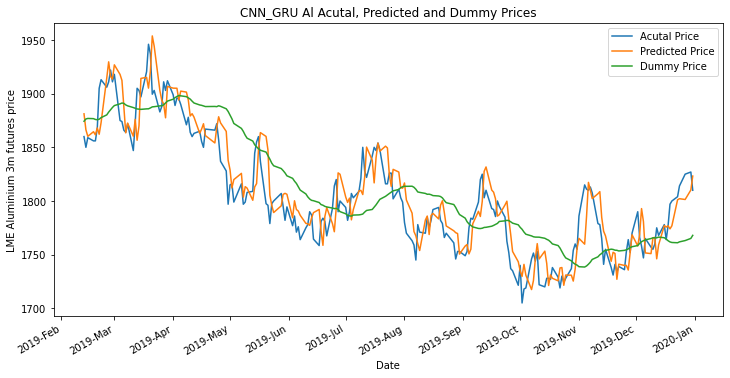

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

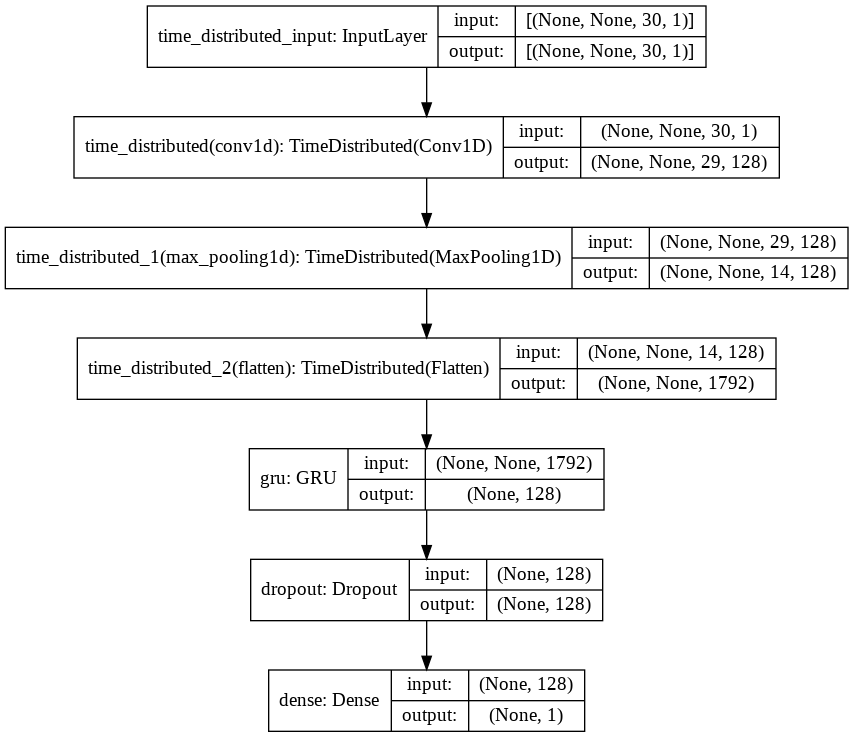

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.007703526844993547
RMSE:  0.08776973763771627
MAE:  0.07036173725184786
Dummy MSE:  0.019334874061718535
Dummy RMSE:  0.13904989774076978
Dummy MAE:  0.11616489589341868


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Al/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Al/assets
